# First Approach to a univariate Long-Short-Term Memory model for predicting the solar output  #

For our optimisation we need solar output predictions. In this notebook we will use a univariate Long-Short-Term Memory model to predict the solar output. 


 https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM


First install all the dependencies:

In [67]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import permutations

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout, LSTM , Conv1D, MaxPooling1D  # create layers


from sklearn.model_selection import train_test_split
 
np.random.seed(42)
tf.random.set_seed(42)


We will start with loading the pickle file with our full dataset into this notebook. 



In [68]:
df = pd.read_pickle("../data/final_dataframe.pkl")

The column names are not very easy to work with and can be a bit hard to read. Therefore we will rename them to make them easier to read.

In [69]:
def col_names(df):
    ''' this function renames the columns to make them easier to read 
      additionally set the date as index in our dataframe'''
    column_names = {'Photovoltaics [MWh] Original resolutions': 'Solar_generation_MWh',
                'Photovoltaics [MW] Calculated resolutions': 'Solar_installed_MW',
                'Total (grid load) [MWh] Original resolutions': 'Total_consumption_MWh',
                'Germany/Luxembourg [€/MWh] Calculated resolutions': 'DE_LU_price_per_MWh',}
    df.rename(columns=column_names, inplace=True)
    #df.set_index('Date', inplace=True)
    return df

col_names(df)


,Date,Solar_generation_MWh,Solar_installed_MW,Total_consumption_MWh,DE_LU_price_per_MWh,normalisation_factor,Solar_generation_MWh_normalized
0,2018-10-01 00:00:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
1,2018-10-01 00:15:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
2,2018-10-01 00:30:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
3,2018-10-01 00:45:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
4,2018-10-01 01:00:00,0.0,42805.0,10589.75,56.10,0.684015,0.0
...,...,...,...,...,...,...,...
163675,2023-06-01 22:45:00,0.0,62579.0,12945.50,95.41,1.000000,0.0
163676,2023-06-01 23:00:00,0.0,62579.0,12817.75,86.53,1.000000,0.0
163677,2023-06-01 23:15:00,0.0,62579.0,12539.00,86.53,1.000000,0.0
163678,2023-06-01 23:30:00,0.0,62579.0,12371.00,86.53,1.000000,0.0


Now we can already split the data into train and test set. Important to note here is that the shuffle has to be false otherwise the split is not appropriate for time series analysis. I will use the previously defined approach from the 20230704_train_val_test_split notebook 

In [70]:
# I have a huge problem with the 0 therfore I will add 1 to all my datapoints 
#df['Solar_generation_MWh_normalized'] = df['Solar_generation_MWh_normalized'] + 1

In [71]:
target = ['Date', 'Solar_generation_MWh_normalized']

In [72]:
def test_train_timeseries(df):
    ''' In the first part we select the train and test data.
    In the second per the columns we want to use for our predictions '''
    
    test = df[df.Date >= '2022-06-01']
    train = df[df.Date < '2022-06-01']

    # now we select the columns we want to use for our predictions

    test = test[target]
    train = train[target]
    return test, train

test, train = test_train_timeseries(df)

In [73]:
#Alternatively we could also use 
#train, test = train_test_split(df[['Solar_generation_MWh_normalized']], test_size=.25, shuffle=False)

In [74]:
test

,Date,Solar_generation_MWh_normalized
128544,2022-06-01 00:00:00,0.0
128545,2022-06-01 00:15:00,0.0
128546,2022-06-01 00:30:00,0.0
128547,2022-06-01 00:45:00,0.0
128548,2022-06-01 01:00:00,0.0
...,...,...
163675,2023-06-01 22:45:00,0.0
163676,2023-06-01 23:00:00,0.0
163677,2023-06-01 23:15:00,0.0
163678,2023-06-01 23:30:00,0.0


In [75]:
train

,Date,Solar_generation_MWh_normalized
0,2018-10-01 00:00:00,0.0
1,2018-10-01 00:15:00,0.0
2,2018-10-01 00:30:00,0.0
3,2018-10-01 00:45:00,0.0
4,2018-10-01 01:00:00,0.0
...,...,...
128539,2022-05-31 22:45:00,0.0
128540,2022-05-31 23:00:00,0.0
128541,2022-05-31 23:15:00,0.0
128542,2022-05-31 23:30:00,0.0


I worked nicely

In [76]:
#Let's scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [77]:
#Scale the data for the model #! Test MinMaxScaler 

scalabe = ['Solar_generation_MWh_normalized']

scaler = StandardScaler()
train[scalabe] = scaler.fit_transform(train[scalabe])
test[scalabe] = scaler.transform(test[scalabe])

In [78]:
test

,Date,Solar_generation_MWh_normalized
128544,2022-06-01 00:00:00,-0.624547
128545,2022-06-01 00:15:00,-0.624547
128546,2022-06-01 00:30:00,-0.624547
128547,2022-06-01 00:45:00,-0.624547
128548,2022-06-01 01:00:00,-0.624547
...,...,...
163675,2023-06-01 22:45:00,-0.624547
163676,2023-06-01 23:00:00,-0.624547
163677,2023-06-01 23:15:00,-0.624547
163678,2023-06-01 23:30:00,-0.624547


old version ....
 split a univariate sequence into samller samples to feed into the LSTM
def split_sequence(input, n_steps, pred_size):
    x, y = list(), list()
    for i in range(len(input)):
        end_ix = i + n_steps # find the end of this pattern
        if end_ix+pred_size > len(input)-1: # check if we are beyond the sequence
            break
        seq_x, seq_y = input[i:end_ix], input[end_ix: end_ix+pred_size]# gather input and output parts of the pattern
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.squeeze(np.array(y))

In [79]:
# split a univariate sequence into samller samples to feed into the LSTM
def split_sequence(input, n_steps, pred_size, target = []):
    ''' This function will split our timeseries into supervised timeseries snipets. 
    input = dataframe to be split
    n_steps = length of the X_variable 
    pred_size = length of the y_variable
    features = list of targets to be split
    At the same time we will collect the corresponding timestamps in two additional arrays '''
    input_array = input[target]
    date_array = input['Date']

    x_index, y_index = list(), list()
    x, y = list(), list()
    for i in range(len(input_array)):
        end_ix = i + n_steps # find the end of this pattern
        if end_ix+pred_size > len(input)-1: # check if we are beyond the sequence
            break
        seq_x, seq_y = input_array[i:end_ix], input_array[end_ix: end_ix+pred_size]# gather input and output parts of the pattern
        ind_x, ind_y = date_array[i:end_ix], date_array[end_ix: end_ix+pred_size]# gather input and output Dates of the pattern
        x.append(seq_x)
        y.append(seq_y)
        x_index.append(ind_x)
        y_index.append(ind_y)

    
    return np.array(x), np.squeeze(np.array(y)), np.array(x_index), np.squeeze(np.array(y_index)) 

In [80]:
# define input sequence
input = train
# choose a number of time steps
n_steps = 672
# prediction size 
pred_size= 96

target = ['Solar_generation_MWh_normalized']

# split into samples
X, y, X_train_index, Y_train_index = split_sequence(input, n_steps, pred_size, target)
# summarize the data
print(len(X), len(y))


127776 127776


In [81]:
print(X.shape, y.shape)

print(X_train_index.shape, Y_train_index.shape)

(127776, 672, 1) (127776, 96)
(127776, 672) (127776, 96)


In [82]:
X_test, y_test, X_test_index, Y_test_index = split_sequence(test , n_steps, pred_size, target)

In [83]:
print(X_test.shape, y_test.shape)

print(X_test_index.shape, Y_test_index.shape)

(34368, 672, 1) (34368, 96)
(34368, 672) (34368, 96)


In [84]:
#Now we have to define the validation set for our model #! I see this approach is not so useful, therefore I will use the train test split with shuffling to obtain the validation data. Here i am not loosing the lateest data for training my model 
def val_set(X,y):
    X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    return X, X_val, y, y_val
    #! old approach
    #train_size = round(len(X) * 0.8)
    #X = X[:train_size, :]
    #X_val = X[train_size:, :]
    #y = y[:train_size, :]
    #y_val = y[train_size:, :]
    
X, X_val, y, y_val = val_set(X, y)

In [85]:
y_val.shape

(25556, 96)

In [86]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
 #! correction still necessary

def reshape_for_LSTM(X, y, features):
    features
    X = X.reshape((X.shape[0], X.shape[1], features))
    y = y.reshape((y.shape[0], y.shape[1]))
    return X, y

In [87]:
X, y = reshape_for_LSTM(X, y, 1)

In [88]:
X_val, y_val = reshape_for_LSTM(X_val, y_val, 1)

In [89]:
X_test, y_test = reshape_for_LSTM(X_test, y_test, 1)

In [90]:
X_val.shape

(25556, 672, 1)

In [91]:
X.shape

(102220, 672, 1)

## Lets start the modeling approach using the Long short term memory model ##



In [92]:
# Define dictionary to store results
history = {}

# Define number of epochs and learning rate decay
N_TRAIN = len(X)
EPOCHS = 50
BATCH_SIZE = 2600 # total sample size = 97593 each batch 2600 samples (49 batches ) #! has to be adjusted further to improve
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay( 
    0.001,  #! please adjust and finetune ? should be fine like this 
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)


# Define optimizer used for modelling
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule, name='Adam')  # due to a warning message I used the legacy.Adam 

In [93]:
# Define path where checkpoints should be stored
checkpoint_path = "modeling/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0) # Set verbose != 0 if you want output during training 

#create a callback to stop early once there is no improvement in the loss
cp_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',
                                restore_best_weights=True,
                                verbose = True)

Note how many output layer are needed for predicting several timestamps? Please check one output layer is enough but some of the parameters have to be adjusted,

n_steps, n_features
X.shape[1], X.shape[2]

reason for not having activation functions https://datascience.stackexchange.com/questions/66594/activation-function-between-lstm-layers
https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell

output layer structure : https://stackoverflow.com/questions/46797891/output-shape-of-lstm-model#46799544

https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e

In [94]:
#from keras.layers import Dense, Activation, Dropout, LSTM , Conv1D, MaxPooling1D, LeakyReLU

In [95]:
def get_simple_LSTM_model():
    simple_LSTM = tf.keras.Sequential([
      tf.keras.layers.Conv1D(32, kernel_size = 5, activation ='relu', input_shape =(X.shape[1], X.shape[2])),
      tf.keras.layers.MaxPooling1D(pool_size = 2),
      tf.keras.layers.LSTM(45, kernel_initializer = 'uniform', return_sequences=True), # ! units are not set in stone yet 
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.LSTM(32, return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.LSTM(32, return_sequences=False),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(y.shape[1] ,kernel_initializer = 'uniform', activation='linear') #96 to predict a day 
    ])

    simple_LSTM.compile(optimizer=optimizer,
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    return simple_LSTM

In [96]:
with tf.device('/cpu:0'):
    simple_LSTM = get_simple_LSTM_model()
    print(simple_LSTM.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 668, 32)           192       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 334, 32)           0         
 g1D)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 334, 45)           14040     
                                                                 
 dropout_6 (Dropout)         (None, 334, 45)           0         
                                                                 
 lstm_7 (LSTM)               (None, 334, 32)           9984      
                                                                 
 dropout_7 (Dropout)         (None, 334, 32)           0         
                                                      

In [97]:
with tf.device('/cpu:0'):
    history = simple_LSTM.fit(X,
                        y,
                        batch_size= BATCH_SIZE,
                        validation_data= (X_val, y_val),   ##### probably best to make validation data D #! TO DO 
                        verbose=10,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS,
                        shuffle = False, 
                        callbacks=[cp_callback, cp_early_stop]) # try without early stopping to see if there is something wrong cp_early_stop #!patience=5 helps to aviod getting stuck in local minima 

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Restoring model weights from the end of the best epoch: 16.
Epoch 21: early stopping


In [98]:
#with tf.device('/cpu:0'):
#    simple_LSTM_reloaded = tf.keras.models.load_model('saved_model/simple_LSTM')
STOP
# Check its architecture
#simple_LSTM_reloaded.summary()

NameError: name 'STOP' is not defined

In [ ]:
#Save the entire small model as a SavedModel.
#!mkdir -p ../models/saved_model
#simple_LSTM.save('../models/saved_model/simple_LSTM_good')

In [99]:
history.history

{'loss': [0.8483347296714783,
  0.5733506083488464,
  0.45766717195510864,
  0.3970829248428345,
  0.33884087204933167,
  0.28191933035850525,
  0.22895336151123047,
  0.20850348472595215,
  0.20233416557312012,
  0.19393911957740784,
  0.1710493564605713,
  0.17681719362735748,
  0.16815093159675598,
  0.15475717186927795,
  0.16546346247196198,
  0.1566966325044632,
  0.15691566467285156,
  0.14258532226085663,
  0.1573796421289444,
  0.14179420471191406,
  0.14840053021907806],
 'mean_absolute_percentage_error': [108.60807037353516,
  155.84457397460938,
  172.29261779785156,
  181.48614501953125,
  167.19952392578125,
  174.9529571533203,
  156.92977905273438,
  160.3831787109375,
  140.78018188476562,
  147.58876037597656,
  138.1831512451172,
  141.0912322998047,
  141.60055541992188,
  131.18032836914062,
  138.17977905273438,
  136.92361450195312,
  136.12611389160156,
  124.1062240600586,
  134.5943145751953,
  126.52568817138672,
  129.2911834716797],
 'val_loss': [1.07958579

In [100]:
scores = simple_LSTM.evaluate(X, y)

3195/3195 [==============================] - 103s 32ms/step - loss: 0.1071 - mean_absolute_percentage_error: 111.1572


In [101]:
print("\n%s: %.2f%%" % (simple_LSTM.metrics_names[1], scores[1]))


mean_absolute_percentage_error: 111.16%


In [102]:
X_test
#x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], 1))
y_pred = simple_LSTM.predict(X_test, verbose=0)
print(y_pred)

[[-0.6315497  -0.65770525 -0.66351026 ... -0.6549516  -0.6543719
  -0.6341517 ]
 [-0.62495965 -0.64988256 -0.659237   ... -0.6585883  -0.65932494
  -0.6364062 ]
 [-0.616673   -0.63772416 -0.6511651  ... -0.6576188  -0.66019744
  -0.6349654 ]
 ...
 [-0.6449452  -0.64515275 -0.6594088  ... -0.60163164 -0.6061623
  -0.6077352 ]
 [-0.6584901  -0.6558235  -0.67509764 ... -0.62608033 -0.6227352
  -0.6233615 ]
 [-0.6619007  -0.6585192  -0.68056154 ... -0.6412638  -0.6330098
  -0.6324433 ]]


In [ ]:
print("Evaluate on test data")
results = simple_LSTM.evaluate(X_test, y_test, batch_size=2600)
print("test loss, test acc:", results)

Evaluate on test data
14/14 [==============================] - 22s 2s/step - loss: 76.5675 - mean_absolute_percentage_error: 76.5675
test loss, test acc: [76.56754302978516, 76.56754302978516]


In [ ]:
#simple_LSTM.save('../models/saved_model/simple_LSTM_70error')

Lets now make a new timeseries from out predicted values so we can plot them nicely

In [103]:
def make_plotting_table(y_test, y_pred, Y_test_index):
    inversed_y_test = scaler.inverse_transform(y_test)
    inversed_y_pred = scaler.inverse_transform(y_pred)
    inversed_y_test = pd.DataFrame(inversed_y_test[:1, :].T, columns=['should'])
    Date = pd.DataFrame(Y_test_index[:1, :].T, columns=['Date'])
    inversed_y_pred = pd.DataFrame(inversed_y_pred[:1, :].T, columns=['is'])
    df_date = Date
    df_3 = pd.concat([df_date, inversed_y_test], axis=1)
    df_plotting = pd.concat([df_3, inversed_y_pred] ,axis=1)
    df_melted = df_plotting.melt(id_vars = 'Date', value_vars=['is', 'should'], var_name = 'Variable', value_name = "Value")
    df_melted["Date"] = pd.to_datetime(df_melted['Date'])
    return df_melted

In [104]:
df_plotting = make_plotting_table(y_test, y_pred, Y_test_index)

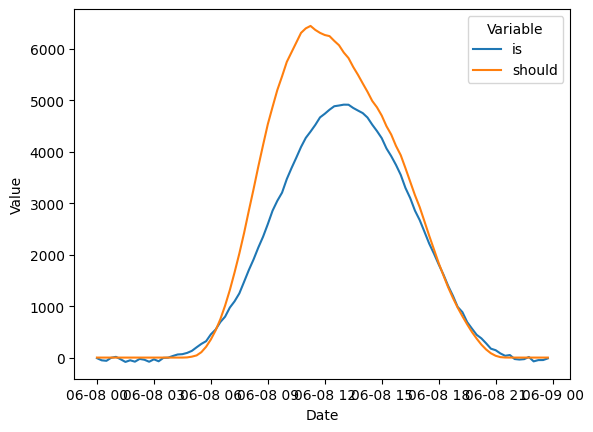

In [105]:
LSTM_solar_output = sns.lineplot(data=df_plotting, x = 'Date' , y = 'Value', hue = 'Variable')

The results are still not very good. It seems that there are some problems with handeling the 0 and also the seasonality. More work is needed. 
    Option 1: I will remove the seasonality from the data before it goes into the model 
    Option 2: I will include the price and weather data to make the model more robust. 

### Let's now create a proper output table which can then be used for the Optimisation ###
Now we will transform out output back into the same units as before and add them to a dataframe. 

In [106]:
def reverse_and_frame(X, y, X_test_index):
    ''' The input are both our arrays X_test and the predicted y and the date index of the original X_test array.

     1st. Inverse transfrom the arrays to the original dimensions needed by the optimizer 
     2nd. Create a dataframe for both x_test and y_pred 
     3rd. Merge all the columns representing the timesteps into a single array in one column 
     4th. Create an empty dataframe and add the last date of X_test_index as the timepoint from which the prediction started
     5th  Concatenate the two dataframes into one 
    '''
    inversed_y_pred = scaler.inverse_transform(y)
    inversed_X_test = scaler.inverse_transform(X.reshape(X.shape[0], X.shape[1]))

    X_test = pd.DataFrame(inversed_X_test)
    y_pred = pd.DataFrame(inversed_y_pred)

    X_test['input_array'] = X_test.apply(lambda row: np.array(row), axis=1)
    y_pred['output_array'] = y_pred.apply(lambda row: np.array(row), axis=1)

    df_final = pd.DataFrame()
    df_final["Date"]= X_test_index[:, -1]

    df_final['output'] = y_pred['output_array']
    df_final['input'] = X_test['input_array']
    return df_final

In [107]:
solar_predictions= reverse_and_frame(X_test, y_pred, X_test_index)

### include the date and time column back to the output dataframe ###

In [108]:
solar_predictions

,Date,output,input
0,2022-06-07 23:45:00,"[-11.280065, -53.410007, -62.76047, -3.8239489...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-06-08 00:00:00,"[-0.6650743, -40.809666, -55.877293, 9.141688,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-06-08 00:15:00,"[12.682643, -21.22556, -42.875584, 22.695827, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2022-06-08 00:30:00,"[31.294216, 7.299464, -20.735691, 39.340603, 5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2022-06-08 00:45:00,"[57.90054, 46.636196, 13.179347, 62.010036, 72...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
34363,2023-05-31 22:30:00,"[72.84988, 55.043423, 55.606533, 29.463406, 40...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34364,2023-05-31 22:45:00,"[10.223781, 1.7900038, -9.646581, -15.838414, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34365,2023-05-31 23:00:00,"[-32.856785, -33.191135, -56.154026, -44.85739...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34366,2023-05-31 23:15:00,"[-54.67429, -50.379, -81.42478, -56.45151, -28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [109]:
df_solar_predictions = solar_predictions[['Date', 'output']].copy()

In [110]:
df_solar_predictions.to_pickle("../predictions/solar_predictions.pkl")

In [ ]:
# Save the entire small model as a SavedModel.
#!mkdir -p ../models/saved_model
#simple_LSTM.save('../models/saved_model/simple_LSTM_2')

### Short summary ###
model is performing poorly, the overall MAPE is still around 65 % error which is helpful for our approach. Based on the output I is not able to handle the 0 very well. I will now look a bit deeper into the 0 problem. 

### Alternative approach get rid of the seasonality beforehand 

TO DO